In [1]:
import numpy as np
import random
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch import optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [3]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, anchor, positive, negative):
        output1 = self.embedding_net(anchor)
        output2 = self.embedding_net(positive)
        output3 = self.embedding_net(negative)
        return output1, output2, output3


In [4]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        
        self.fc = nn.Sequential(nn.Linear(300, 100),
                                nn.PReLU(),
                                nn.Linear(100, 2))        

    def forward(self, x):
        output = self.fc(x)
        return output

    def get_embedding(self, x):
        return self.forward(x)


In [5]:
class TripletDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
        self.keys = list(dataset.keys())

    def __getitem__(self, index):
        word = self.keys[index]
        
        anchor = self.dataset[word]['word_vector'] 
        positive = self.dataset[word]['antonym_vector']
        
        negative_word = word
        while (negative_word == word) | (negative_word == self.dataset[word]['antonym']):
            negative_word = np.random.choice(self.keys)    
            negative = self.dataset[negative_word]['word_vector']
        
        
        return (anchor, positive, negative), []

    def __len__(self):
        return len(self.dataset)

In [6]:
def plotter(history):
    _hist = np.array(history)
    train_loss, val_loss = _hist[:, 1], _hist[:, 2]

    clear_output(True)
    plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='vall loss')
    plt.grid()
    plt.legend()

    plt.show()
    
    for epoch, train_loss, val_loss in history:
        print(f'Epoch {epoch}')
        print('Train Loss: {:.4f}'.format(train_loss),
              '| Val Loss: {:.4f}'.format(val_loss))
        print()


In [7]:
with open('./fasttext-wiki-news-subwords-300_5120.pickle', 'rb') as f:
    data = pickle.load(f)
len(data)

5120

In [8]:
train = dict(list(data.items())[:4000])
val = dict(list(data.items())[4000:])

len(train), len(val)

(4000, 1120)

In [9]:
triplet_train_dataset = TripletDataset(train) 
train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=31, shuffle=True)

triplet_val_dataset = TripletDataset(val) 
val_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=31, shuffle=True)


In [10]:
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
loss_fn = TripletLoss(margin = 1.)


In [11]:
lr = 1e-3

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)
log_interval = 100

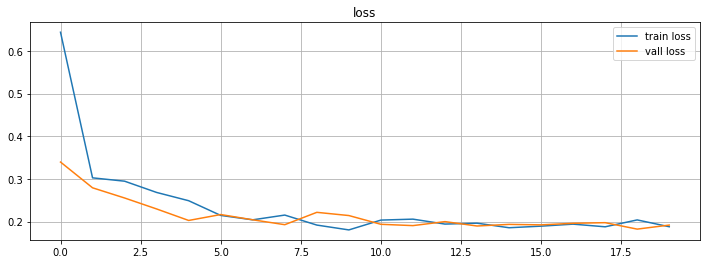

Epoch 0
Train Loss: 0.6434 | Val Loss: 0.3396

Epoch 1
Train Loss: 0.3026 | Val Loss: 0.2793

Epoch 2
Train Loss: 0.2947 | Val Loss: 0.2554

Epoch 3
Train Loss: 0.2684 | Val Loss: 0.2297

Epoch 4
Train Loss: 0.2490 | Val Loss: 0.2028

Epoch 5
Train Loss: 0.2146 | Val Loss: 0.2167

Epoch 6
Train Loss: 0.2043 | Val Loss: 0.2043

Epoch 7
Train Loss: 0.2154 | Val Loss: 0.1929

Epoch 8
Train Loss: 0.1920 | Val Loss: 0.2218

Epoch 9
Train Loss: 0.1807 | Val Loss: 0.2143

Epoch 10
Train Loss: 0.2037 | Val Loss: 0.1938

Epoch 11
Train Loss: 0.2059 | Val Loss: 0.1907

Epoch 12
Train Loss: 0.1943 | Val Loss: 0.2001

Epoch 13
Train Loss: 0.1964 | Val Loss: 0.1898

Epoch 14
Train Loss: 0.1858 | Val Loss: 0.1936

Epoch 15
Train Loss: 0.1895 | Val Loss: 0.1925

Epoch 16
Train Loss: 0.1942 | Val Loss: 0.1962

Epoch 17
Train Loss: 0.1880 | Val Loss: 0.1976

Epoch 18
Train Loss: 0.2041 | Val Loss: 0.1825

Epoch 19
Train Loss: 0.1881 | Val Loss: 0.1920



In [12]:
n_epochs = 20

train_len = len(train_loader)
val_len = len(val_loader)

history = []


for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)
    
    model.train()
    train_loss = 0
    val_loss = 0
    
    scheduler.step()
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), desc="Iteration"):
        optimizer.zero_grad()
        outputs = model(*data)
        loss = loss_fn(*outputs)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval();
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(val_loader), desc="Iteration"):
            outputs = model(*data)
            loss = loss_fn(*outputs)
            val_loss += loss.item()
            
    epoch_train_loss = train_loss / train_len
    epoch_val_loss = val_loss / val_len
    history.append([epoch, epoch_train_loss, epoch_val_loss])
    
    plotter(history)
    
    #print('Training Loss: {:.4f}'.format(epoch_train_loss))
    #print('Validation Loss: {:.4f}'.format(epoch_val_loss))